In [3]:
import os
from os.path import join, dirname, basename
import pandas as pd
import numpy as np
import glob
import rasterio as rio
import rasterio.mask
import fiona
import cv2
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import sys

import utils 

In [83]:
PATH = r'/home/mkhudinyan/GitHub/porto_parque/data'
GEOSAT_PATH = join(PATH, 'Deimos')
OUT_PATH = join(PATH, 'output')
SHAPE_PATH = join(PATH, 'portugal-natural-shape/parque_cidade_boundary.shp')
# TRAIN_PATH = join(PATH, 'sampled_data/pdc_grid_train_random100.csv')
# TRAIN_PATH = join(PATH, 'sampled_data/new_sampled_points/train_test_2017_v2.csv')
TRAIN_PATH = join(PATH, 'sampled_data_orig/train_test_2017_orig.csv')
# TEST_PATH = join(PATH, 'sampled_data/train_2017_v4.csv')

In [84]:
train_samples = pd.read_csv(TRAIN_PATH)
# test_samples = pd.read_csv(TEST_PATH)[test_samples['id_class'] != 7]
# train_samples.drop('fid', axis=1, inplace=True)
print(train_samples.shape)
# print(test_samples.shape)

(1800, 22)


#clean and write csv
train_features = ['id_class', 'DE2_NIR_1', 'DE2_RED_2', 'DE2_GRE_3', 'DE2_BLU_4']
train = train_samples.loc[:, train_features]
train.to_csv(f"{join(PATH, 'sampled_data/train.csv')}", index=False)

### Add vegetation indices and write tiff's

### Note: Do it one time to produce and store the neccessary data

In [26]:
rasters = sorted(glob.glob(join(GEOSAT_PATH, 'original_res/aligned/', '*.tif')))

In [27]:
rasters

['/home/mkhudinyan/GitHub/porto_parque/data/Deimos/original_res/aligned/20170221T112923.tif',
 '/home/mkhudinyan/GitHub/porto_parque/data/Deimos/original_res/aligned/20170328T105352.tif',
 '/home/mkhudinyan/GitHub/porto_parque/data/Deimos/original_res/aligned/20170714T112642.tif']

In [28]:
# simply to check the raster metadata
for raster in rasters:
    print(rio.open(rasters[0]).meta['transform'])
    print(rio.open(rasters[0]).shape)

| 3.93, 0.00, 525910.47|
| 0.00,-3.55, 4558157.45|
| 0.00, 0.00, 1.00|
(316, 451)
| 3.93, 0.00, 525910.47|
| 0.00,-3.55, 4558157.45|
| 0.00, 0.00, 1.00|
(316, 451)
| 3.93, 0.00, 525910.47|
| 0.00,-3.55, 4558157.45|
| 0.00, 0.00, 1.00|
(316, 451)


In [56]:
# Select the image to add bands and save
# should be iterated manually
rast = rasters[2]
src = rio.open(rast) 
bands = src.read().astype('float32') # needed conversion for index calculation

In [57]:
# chekc for missing values
np.isnan(bands).any()

False

In [53]:
# in case of True we run this cell to interpolate missing pixels
bands = utils.fill_nans(bands)

In [58]:
# calculate the indices
single_stack = utils.add_indices(bands)
# check the data size and missing values
single_stack.shape, np.isnan(single_stack).any()

((7, 316, 451), True)

In [59]:
# in case of True we run this cell to interpolate missing pixels
single_stack = utils.fill_nans(single_stack)

there are missing values


In [60]:
# check the raster name before writing it
basename(rast)

'20170714T112642.tif'

In [61]:
# write rasters with added bands
utils.write_raster(
    single_stack, 
    src, 
    join(GEOSAT_PATH, 'original_res/indices', f'{basename(rast)}'))

### Data Preparation

In [62]:
band_names = ['nir', 'red', 'green', 'blue', 'ndvi', 'ndwi', 'gvi'] 

#### NOTE: check the file's order

In [85]:
# Get the images wirh added vegetation indices and stack all data together
rasters_path = sorted(glob.glob(join(GEOSAT_PATH, 'original_res/indices', '*.tif'))) # Must be sorted not to mess up the order
# rasters_path.sort()
rasters = [rio.open(path).read() for path in rasters_path]
# image_names = sorted([basename(raster).split('_')[4][:8] for raster in rasters_path])

full_stack = np.vstack([raster for raster in rasters])
full_stack = utils.fill_nans(full_stack)
full_stack.shape

(21, 316, 451)

In [86]:
# get raster's names
image_names = sorted([basename(raster)[:8] for raster in rasters_path])
image_names

['20170221', '20170328', '20170714']

In [87]:
src = rio.open(rasters_path[0])

In [88]:
# transform data from (bands, rows, cols) to (rows, cols, bands)  shape
stack_transf = np.moveaxis(full_stack, 0, 2) 
print(stack_transf.shape)
rows, cols, n_bands = stack_transf.shape
n_pixels = rows * cols # number of pixels per band
flat_pixels = stack_transf.reshape((n_pixels, n_bands)) # make flat pixels from bands
print(flat_pixels.shape)

(316, 451, 21)
(142516, 21)


In [89]:
# get names for each variable
var_names = []
for image_name in image_names:
    
    n = list(map(lambda name: '_'.join([image_name, name]), band_names))
    var_names.extend(n)

In [90]:
var_names

['20170221_nir',
 '20170221_red',
 '20170221_green',
 '20170221_blue',
 '20170221_ndvi',
 '20170221_ndwi',
 '20170221_gvi',
 '20170328_nir',
 '20170328_red',
 '20170328_green',
 '20170328_blue',
 '20170328_ndvi',
 '20170328_ndwi',
 '20170328_gvi',
 '20170714_nir',
 '20170714_red',
 '20170714_green',
 '20170714_blue',
 '20170714_ndvi',
 '20170714_ndwi',
 '20170714_gvi']

In [91]:
df = pd.DataFrame(flat_pixels, columns=var_names)

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def RF(X_train, y_train, X_test):
    '''Random Forest Classification'''
    RF = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=34)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    return y_pred

### Prepare data for Analysis

In [95]:
# X_train = train_samples.copy() # Full data
# X_train.drop('id_class', axis=1, inplace=True)
# y_train = train_samples['id_class']
# X_pred = df.copy()  

X = train_samples.copy()
X.drop('id_class', axis=1, inplace=True)
y = train_samples['id_class']
# image data to classify
X_pred = df.copy() # image data             

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.3)

#X_train = train_samples.copy() # Full data
X_train = train_samples.iloc[:, -6:].copy()
#X_train.drop(X_train.iloc[:, 7:13], axis=1, inplace=True)
#X_train.drop('id_class', axis=1, inplace=True)

y_train = train_samples['id_class']
X_pred = df.copy()             # Full data
X_pred = df.iloc[:, -6:]
#X_pred.drop(df.iloc[:, 6:12], axis=1, inplace=True)

In [97]:
# print to see the data splits
X_train.shape, y_train.shape, X_test.shape

((1260, 21), (1260,), (540, 21))

#### Run RandomForest Classification

In [98]:
# Run the classification
y_pred = RF(X_train, y_train, X_test)

#### Plot prediction results

In [47]:
print(confusion_matrix(y_test, y_pred))

[[83  4  0  1  2  0]
 [14 57 12  4  1  2]
 [ 1 13 71  1  1  3]
 [ 5  0  3 77  4  1]
 [ 6  1  0 13 70  0]
 [ 0  4  4  4  0 78]]


In [100]:
labels = ['Grass', 'Broadleaved Trees', 'Coniferous Trees', 'Impervious', 'Bare Soil', 'Water']

In [44]:
print(classification_report(y_test, y_pred, target_names=labels))

                   precision    recall  f1-score   support

            Grass       0.76      0.92      0.83        90
Broadleaved Trees       0.72      0.63      0.67        90
 Coniferous Trees       0.79      0.79      0.79        90
       Impervious       0.77      0.86      0.81        90
        Bare Soil       0.90      0.78      0.83        90
            Water       0.93      0.87      0.90        90

         accuracy                           0.81       540
        macro avg       0.81      0.81      0.81       540
     weighted avg       0.81      0.81      0.81       540



In [102]:
print('Overall Accuracy:', round(accuracy_score(y_test, y_pred), 2))

Overall Accuracy: 0.81


### Image Classification

In [103]:
classif = RF(X_train, y_train, X_pred)

In [104]:
# Reshape back the flattened image into 2d image
classif_map = classif.reshape(rows, cols).astype('float32')

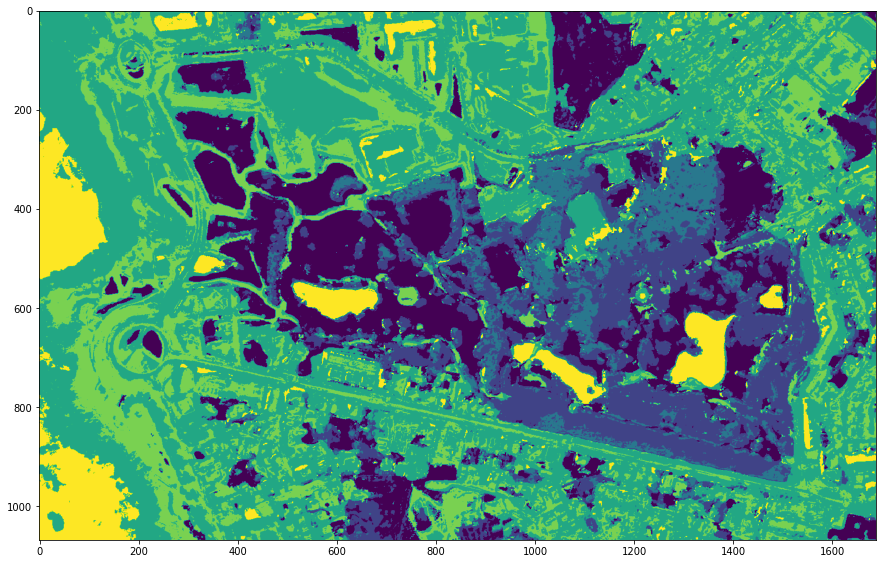

In [55]:
plt.rcParams["figure.figsize"] = (15, 15)
plt.imshow(classif_map)

### Majority filter

In [56]:
# Python implementation of Majority filter is lazy 
# so it takes longer than the actual classification 
map_filt7 = utils.majority_filter(classif_map, block_size = (7,7)).astype('float32')

In [57]:
map_filt_2x7 = utils.majority_filter(map_filt7, block_size = (7,7)).astype('float32')

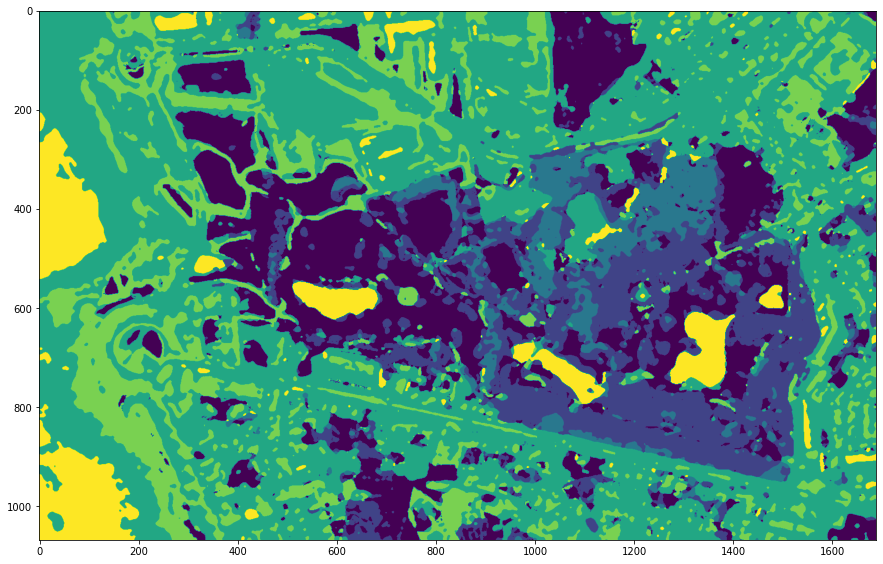

In [58]:
# Plot the filtered image
plt.rcParams["figure.figsize"] = (15, 15)
plt.imshow(map_filt_2x7)

### Write classification result map

Writes the Classification initial output and the clipped raster with Porto parque boundaries

In [59]:
# Trite Tiff files in the output directory
tiff_name = '2017_majFilt_2X7'
DEST_PATH = join(OUT_PATH, f'{tiff_name}.tif')
DEST_CLIP = join(OUT_PATH, f'{tiff_name}_cp.tif')

utils.write_raster(map_filt_2x7, src, DEST_PATH)
utils.tiff_mask2shape(SHAPE_PATH, tiff_path=DEST_PATH, dest_path=DEST_CLIP)

### Image downsampling

#### Note: This was experiments, so it doesn't do anything miningfull at this point

In [46]:
utils.raster_resample(raster_path=DEST_PATH, rescale_factor=1/3, out_dir=OUT_PATH)

### Unsupervised Classification Experiments

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(data

In [13]:
data = np.vstack((bands, ndvi[np.newaxis, :]))
stack_transf = np.moveaxis(data, 0, 2)
rows, cols, n_bands = stack_transf.shape
n_pixels = rows * cols
flat_pixels = stack_transf.reshape((n_pixels, n_bands))
flat_pixels.shape

(1900800, 4)

In [15]:
kmeans = KMeans(
init="random",
n_clusters=13,
n_init=10,
max_iter=30,
random_state=42)

kmeans.fit(flat_pixels)

KMeans(init='random', max_iter=30, n_clusters=13, random_state=42)

In [16]:
print(kmeans.inertia_)
print(kmeans.cluster_centers_)
print(kmeans.n_iter_)

302308699.007546
[[6.12987300e+01 1.98215041e+01 1.79515694e+01 5.14361922e-01]
 [1.54194264e+01 1.71985378e+01 1.79048706e+01 6.27679533e-02]
 [1.60027409e+02 1.40240694e+02 1.33687612e+02 1.75633761e-01]
 [1.05260224e+02 3.05208269e+01 2.95776977e+01 5.52731464e-01]
 [7.79711095e+01 4.54304322e+01 3.91982312e+01 2.63837374e-01]
 [3.17434360e+01 3.35731742e+01 3.23126197e+01 5.00448605e-02]
 [3.90322043e+01 1.57688792e+01 1.40253561e+01 4.32344965e-01]
 [1.09852934e+02 9.70226038e+01 8.86139046e+01 6.96209028e-02]
 [6.22620729e+01 5.77298348e+01 5.34574352e+01 5.66145701e-02]
 [1.31815413e+02 3.04201097e+01 3.21585075e+01 6.26010957e-01]
 [8.30322629e+01 2.46850998e+01 2.29222110e+01 5.43098143e-01]
 [5.47064303e+01 3.81383190e+01 3.32210092e+01 1.79320985e-01]
 [9.62001228e+01 6.79092667e+01 5.84641034e+01 1.71068687e-01]]
30


In [17]:
classif_map = np.reshape(kmeans.labels_.astype('float32'), (rows, cols))

In [18]:
np.unique(classif_map, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
       dtype=float32),
 array([214176, 182049,   8333, 168615, 148763, 105955, 216657,  66871,
        155812,  97434, 209271, 218750, 108114]))

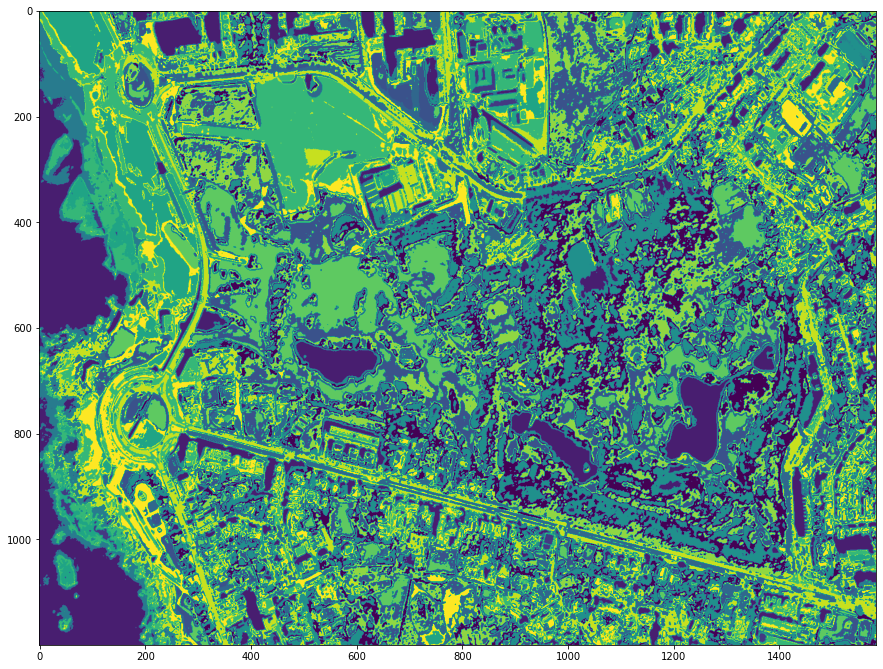

In [19]:
plt.rcParams["figure.figsize"] = (15, 15)
plt.imshow(classif_map)